# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn
import sklearn

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
sss.get_n_splits(train_images, train_labels)
(train_indices, validation_indices) = next(sss.split(train_images, train_labels))
(validation_images, validation_labels) = (train_images[validation_indices], train_labels[validation_indices])
(train_images, train_labels) = (train_images[train_indices], train_labels[train_indices])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [3]:
train_images_expanded = np.expand_dims(train_images, axis = 3)
validation_images_expanded = np.expand_dims(validation_images, axis = 3)
test_images_expanded = np.expand_dims(test_images, axis = 3)
with tf.device('CPU:0'):
    train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
    validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [5]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks, initial_epoch = 0):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    with tf.device('GPU:0'):
        history = model_name.fit(
        ti, tl,
        epochs = epochs,
        initial_epoch = initial_epoch,
        validation_data = (vi, vl))
        model_name.summary()
    return history
def write_to_json(dictionary, gmean, fscore, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    dictionary['fscore'] = str(fscore)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [6]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 2, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 57000 samples, validate on 3000 samples
Epoch 1/2
57000/57000 [==============================] - 8s 147us/sample - loss: 0.3541 - acc: 0.9027 - val_loss: 0.1330 - val_acc: 0.9587
Epoch 2/2
57000/57000 [==============================] - 7s 117us/sample - loss: 0.1022 - acc: 0.9697 - val_loss: 0.0899 - val_acc: 0.9750
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 56)        14168     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 56)          0         
___________________________________________________________

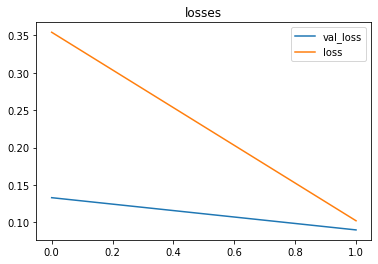

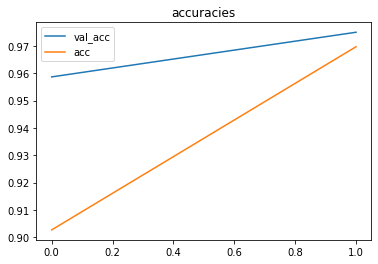

In [7]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [8]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.9766920094597688 
fscore: 0.9769092025836457


In [9]:
write_to_json(history.history, baseline_gmean, baseline_fscore, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.1 \rho=1000$

In [10]:
tf.compat.v1.random.set_random_seed(1234)

{0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5, 7: 5150, 8: 5150, 9: 5150}
sorted


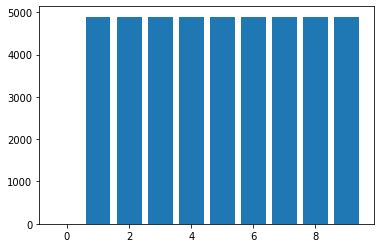

real


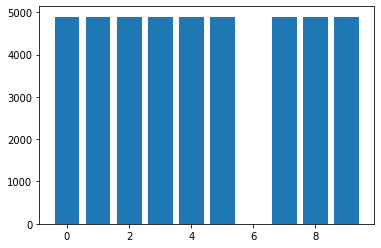

rho = 978.6


In [11]:
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, 
                                                                              train_labels, np.float32(0.1), 1000)
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
    sss.get_n_splits(imb_train_images, imb_train_labels)
    (imb_train_indices, imb_validation_indices) = next(sss.split(imb_train_images, imb_train_labels))
    (imb_validation_images, imb_validation_labels) = (imb_train_images[imb_validation_indices], imb_train_labels[imb_validation_indices])
    (imb_train_images, imb_train_labels) = (imb_train_images[imb_train_indices], imb_train_labels[imb_train_indices])    
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_validation_images_expanded = np.expand_dims(imb_validation_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0
    imb_validation_images_tf = tf.cast(imb_validation_images_expanded, dtype = tf.float32) / 255.0

In [12]:
min_label = min(hf.Imbalance.get_set_distribution(imb_train_labels))
min_label

0

## check model behavior on untouched imbalanced set

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [14]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 5, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 44037 samples, validate on 2318 samples
Epoch 1/5
44037/44037 [==============================] - 6s 132us/sample - loss: 0.4265 - acc: 0.8741 - val_loss: 0.1708 - val_acc: 0.9538
Epoch 2/5
44037/44037 [==============================] - 5s 117us/sample - loss: 0.1280 - acc: 0.9618 - val_loss: 0.1037 - val_acc: 0.9707
Epoch 3/5
44037/44037 [==============================] - 5s 117us/sample - loss: 0.0853 - acc: 0.9751 - val_loss: 0.0898 - val_acc: 0.9711
Epoch 4/5
44037/44037 [==============================] - 5s 118us/sample - loss: 0.0670 - acc: 0.9802 - val_loss: 0.0571 - val_acc: 0.9797
Epoch 5/5
44037/44037 [==============================] - 5s 118us/sample - loss: 0.0542 - acc: 0.9834 - val_loss: 0.0522 - val_acc: 0.9836
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 28)        280       
____________________________________

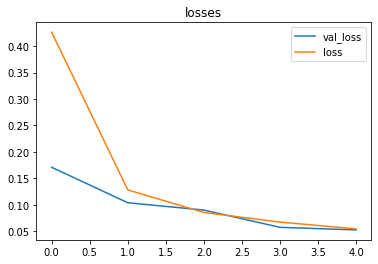

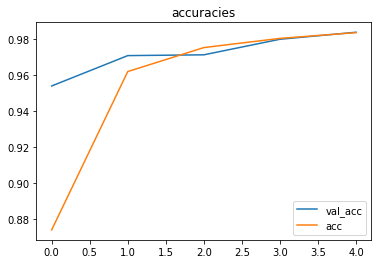

In [15]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [16]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
    print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.5537653787652631 
fscore: 0.8428111861281323


## train and evaluate model on randomly oversampled (ROS) data

In [17]:
print(f'before ros {hf.Imbalance.get_set_distribution(imb_train_labels)}')

(cp_img, cp_labels) = (imb_train_images, imb_train_labels)

imb_train_shape = imb_train_images.shape
imb_train_images = imb_train_images.reshape(imb_train_shape[0], 
                                            imb_train_shape[1] * imb_train_shape[2])



ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
(ros_train_images, ros_train_labels) = ros.fit_resample(imb_train_images, imb_train_labels)



ros_train_images = ros_train_images.reshape(ros_train_images.shape[0], 
                                            imb_train_shape[1], 
                                            imb_train_shape[2])

        
    
permutation = np.random.permutation(np.arange(ros_train_images.shape[0]))
print(permutation)
ros_train_images = ros_train_images[permutation]
ros_train_labels = ros_train_labels[permutation]

print(f'after ros {hf.Imbalance.get_set_distribution(ros_train_labels)}')



ros_train_images_expanded = np.expand_dims(ros_train_images, axis = 3)
with tf.device('CPU:0'):
    ros_train_images_tf = tf.cast(ros_train_images_expanded, dtype = tf.float32) / 255.0

before ros {0: 4892, 1: 4892, 2: 4892, 3: 4893, 4: 4893, 5: 4892, 6: 5, 7: 4893, 8: 4892, 9: 4893}
[38835 31501 38264 ... 30940 33019 22276]
after ros {0: 4893, 1: 4893, 2: 4893, 3: 4893, 4: 4893, 5: 4893, 6: 4893, 7: 4893, 8: 4893, 9: 4893}


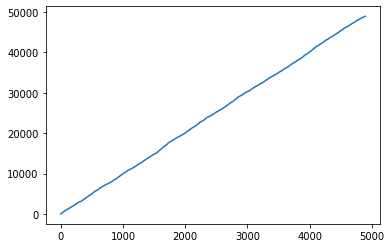

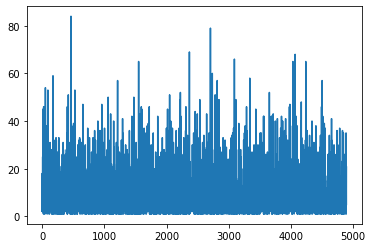

In [18]:
with tf.device('CPU:0'):
    plt.plot(list(np.where(ros_train_labels == min_label)[0]))
    plt.show()
    diff = list()
    for i in range(1, len(list(np.where(ros_train_labels == min_label)[0]))):
        diff.append(list(np.where(ros_train_labels == min_label)[0])[i] - list(np.where(ros_train_labels == min_label)[0])[i - 1])
    plt.plot(diff)

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [20]:
model_ros = tf.keras.models.Sequential()
history = model_run(model_ros, 5, ros_train_images_tf, ros_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
                    optimizer, loss, metrics, callbacks)

Train on 48930 samples, validate on 2318 samples
Epoch 1/5
48930/48930 [==============================] - 6s 132us/sample - loss: 0.4070 - acc: 0.8885 - val_loss: 0.1499 - val_acc: 0.9534
Epoch 2/5
48930/48930 [==============================] - 6s 117us/sample - loss: 0.1075 - acc: 0.9680 - val_loss: 0.0935 - val_acc: 0.9728
Epoch 3/5
48930/48930 [==============================] - 6s 117us/sample - loss: 0.0706 - acc: 0.9784 - val_loss: 0.0724 - val_acc: 0.9750
Epoch 4/5
48930/48930 [==============================] - 6s 118us/sample - loss: 0.0538 - acc: 0.9839 - val_loss: 0.0553 - val_acc: 0.9853
Epoch 5/5
48930/48930 [==============================] - 6s 117us/sample - loss: 0.0443 - acc: 0.9867 - val_loss: 0.0614 - val_acc: 0.9793
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 28)        280       
____________________________________

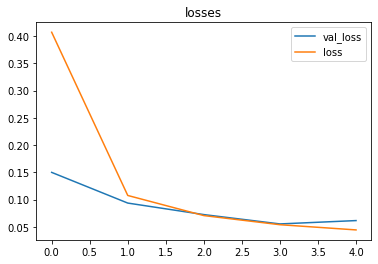

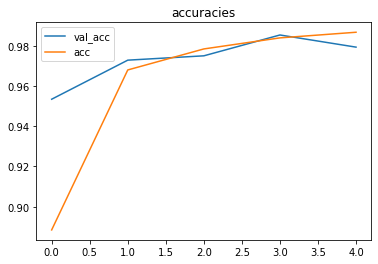

In [21]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [22]:
with tf.device('CPU:0'):
    model_ros_test_preds = tf.argmax(model_ros(test_images_tf), axis=-1)
    model_ros_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_ros_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_ros_fscore = sklearn.metrics.f1_score(test_labels, model_ros_test_preds, average = 'macro')
    print(f'gmean: {model_ros_gmean} \nfscore: {model_ros_fscore}')

gmean: 0.9259321218694949 
fscore: 0.9335323326284142


## train and evaluate model on adversarialy oversampled (AOS) data

create aos model identical to the baseline model on imbalanced data and train until arbitrary convergance

{0: 4892, 1: 4892, 2: 4892, 3: 4893, 4: 4893, 5: 4892, 6: 5, 7: 4893, 8: 4892, 9: 4893}
sorted


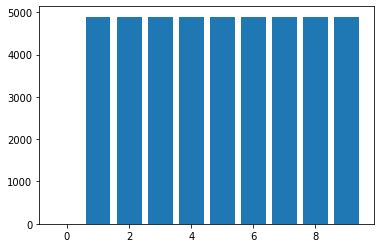

real


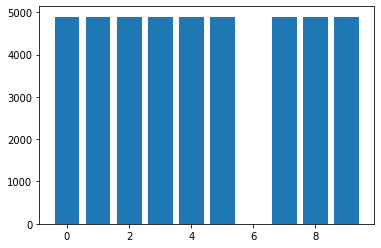

rho = 978.6


In [23]:
(imb_train_images, imb_train_labels) = (cp_img, cp_labels)
print(hf.Imbalance.get_set_distribution(imb_train_labels))
hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [25]:
model_aos = tf.keras.models.Sequential()
history = model_run(model_aos, 2, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 44037 samples, validate on 2318 samples
Epoch 1/2
44037/44037 [==============================] - 6s 127us/sample - loss: 0.4340 - acc: 0.8713 - val_loss: 0.1673 - val_acc: 0.9491
Epoch 2/2
44037/44037 [==============================] - 5s 117us/sample - loss: 0.1264 - acc: 0.9620 - val_loss: 0.1055 - val_acc: 0.9685
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 56)        14168     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 56)          0         
_________________________________________________________

In [26]:
distribution = hf.Imbalance.get_set_distribution(imb_train_labels)
aos_train_images, aos_train_labels = hf.Adversarial.oversample(imb_train_images_expanded, imb_train_labels,
                                                   tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                                                   model_aos, np.linspace(0, 0.1, 10), 
                                                   data_type = 'step')


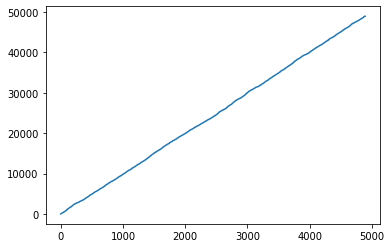

9.450653891549187


In [27]:
with tf.device('CPU:0'):
    plt.plot(list(np.where(aos_train_labels == min_label)[0]))
    plt.show()
    diff = list()
    for i in range(1, len(list(np.where(aos_train_labels == min_label)[0]))):
        diff.append(list(np.where(aos_train_labels == min_label)[0])[i] - list(np.where(aos_train_labels == min_label)[0])[i - 1])
    print(np.std(diff))

{0: 4892, 1: 4892, 2: 4892, 3: 4893, 4: 4893, 5: 4892, 6: 4893, 7: 4893, 8: 4892, 9: 4893}


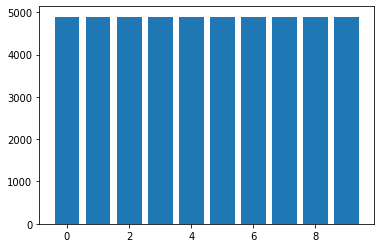

mu = 0.5, rho = 1.000204415372036


In [28]:
print(hf.Imbalance.get_set_distribution(aos_train_labels))
hf.Imbalance.plot_set_distribution(aos_train_images, aos_train_labels)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [30]:
with tf.device('CPU:0'):
    aos_train_images = np.true_divide(aos_train_images, 255.0)
    aos_train_images_tf = tf.cast(aos_train_images, dtype = tf.float32)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

model_aos = tf.keras.models.Sequential()
history = model_run(model_aos, 3, aos_train_images_tf, aos_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 48925 samples, validate on 2318 samples
Epoch 1/3
48925/48925 [==============================] - 6s 132us/sample - loss: 0.3803 - acc: 0.8904 - val_loss: 0.1588 - val_acc: 0.9508
Epoch 2/3
48925/48925 [==============================] - 6s 117us/sample - loss: 0.1007 - acc: 0.9703 - val_loss: 0.0856 - val_acc: 0.9741
Epoch 3/3
48925/48925 [==============================] - 6s 117us/sample - loss: 0.0676 - acc: 0.9794 - val_loss: 0.0643 - val_acc: 0.9789
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 56)        14168     
__________________________________________________

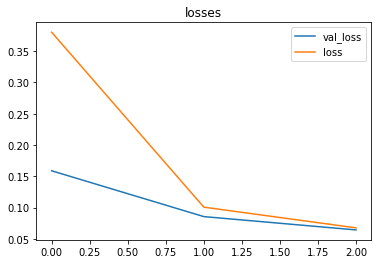

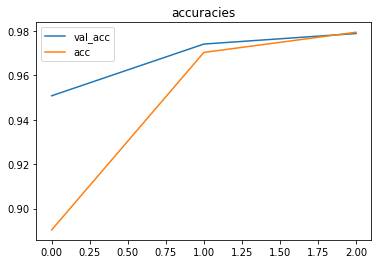

In [32]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [33]:
with tf.device('CPU:0'):
    model_aos_test_preds = tf.argmax(model_aos(test_images_tf), axis=-1)
    model_aos_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_aos_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_aos_fscore = sklearn.metrics.f1_score(test_labels, model_aos_test_preds, average = 'macro')
    print(f'gmean: {model_aos_gmean} \nfscore: {model_aos_fscore}')

gmean: 0.9376810845661833 
fscore: 0.9426868391241309


In [35]:
with tf.device('CPU:0'):
    print(np.sum(tf.argmax(model_aos(test_images_tf), axis = -1) == test_labels))
    print(np.sum(tf.argmax(model_ros(test_images_tf), axis = -1) == test_labels))

9477
9405
